### 2. Autoencoders

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.spatial import distance

In [6]:
def plotImages(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name + '_vis.png')
    plt.show()
    
def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X  # corrupted X

    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)  # hidden state
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)  # reconstructed input
    return Z

def latent(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X  # corrupted X

    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)  # hidden state
    #print Y.shape
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)  # reconstructed input
    return Y


### N = 2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 60793.0

Predicted Images:


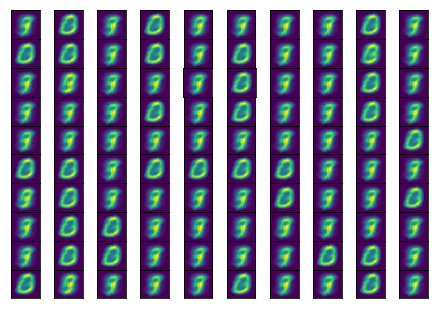


Printing reconstruction error: 
0.0634134

Input Images


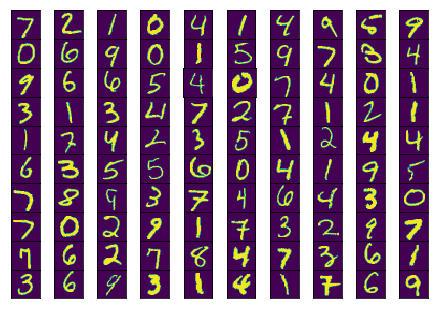


plotting Loss


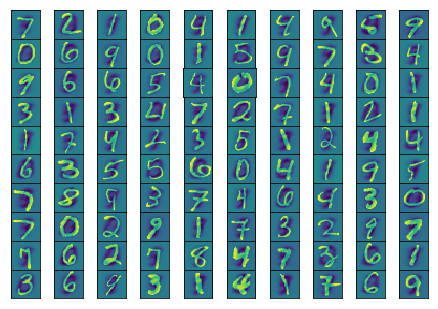

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
Preceision for 50 nearest neighbors:  
1.0
Recall for 50 nearest neighbors:  
0.26


In [8]:
mnist_width = 28
numVisible = mnist_width * mnist_width
numHidden = 2
corruption_level = 0.3

# create node for input data
X = tf.placeholder("float", [None, numVisible], name='X')

# create node for corruption mask
mask = tf.placeholder("float", [None, numVisible], name='mask')

# create nodes for hidden variables
maxInitW = 4 * np.sqrt(6. / (numVisible + numHidden))
initW = tf.random_uniform(shape=[numVisible, numHidden],
                           minval=-maxInitW,
                           maxval=maxInitW)

W = tf.Variable(initW, name='W')
b = tf.Variable(tf.zeros([numHidden]), name='b')

W_prime = tf.transpose(W)  # tied weights between encoder and decoder
b_prime = tf.Variable(tf.zeros([numVisible]), name='b_prime')


# build model graph
Z = model(X, mask, W, b, W_prime, b_prime)
Y = latent(X, mask, W, b, W_prime, b_prime)
# create cost function
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)  # construct an optimizer
predict_op = Z
latent_op = Y
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

trainX = trainX[:1000]
trainY = trainY[:1000]
testX = testX[:1000]
testY = testY[:1000]


# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(100):
        for start, end in zip(range(0, len(trainX), 128), range(128, len(trainX)+1, 128)):
            input_ = trainX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, testX.shape)
        if i%1000 ==0:
            print(i, sess.run(cost, feed_dict={X: testX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, testX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: testX[:100], mask: mask_np})
    latent_imgs = sess.run(latent_op, feed_dict={X: testX[:100], mask: mask_np})
    input_imgs = testX[:100]
    input_labs = testY[:100]


# Plot the reconstructed images
print()
print ('Predicted Images:')
plotImages(predicted_imgs,'pred')

print()
print("Printing reconstruction error: ")
loss = ((testX[:100] - predicted_imgs) ** 2).mean()
print(loss)

print()
print ('Input Images')
plotImages(input_imgs, 'input')


print ()
print ('plotting Loss')
plotImages(testX[:100] - predicted_imgs, 'loss')

#############################################
#Calculating latent space similarity

seed  = latent_imgs[0]
eudist = [0]

for i in range(len(latent_imgs)-1):
    eudist.append(np.linalg.norm(seed-latent_imgs[i+1]))

#print(eudist)
    
close = sorted(range(len(eudist)), key=lambda k: eudist[k])
close = close[:50]
#print(input_labs[close])
#vis(input_imgs[close], 'nearest')

tp =0
fn =0

neighbors = input_labs[close]
seed_lab = neighbors[0]
print(seed_lab)
for vec in range(len(neighbors)-1):
    if all(np.array(seed_lab) == np.array(neighbors[vec+1])):
        tp = tp+1
#print(tp)

fn = 50 - tp
fp = 0

print("Preceision for 50 nearest neighbors:  "),
print(float(tp)/float(tp+fp))
print("Recall for 50 nearest neighbors:  "),
print(float(tp)/float(tp+fn))

#################################################################

### N = 5

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 59399.6

Predicted Images:


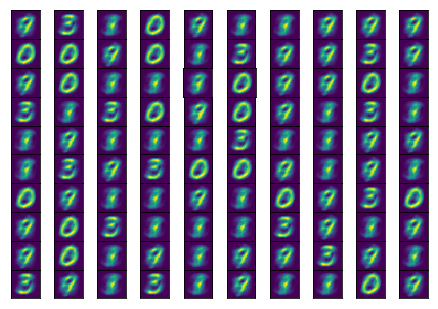


Printing reconstruction error: 
0.0597712

Input Images


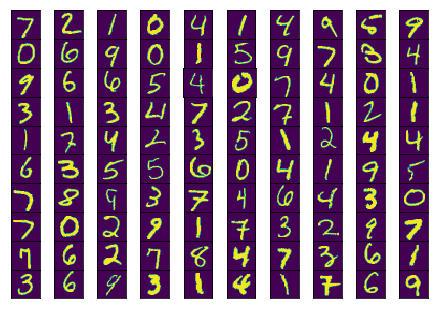


plotting Loss


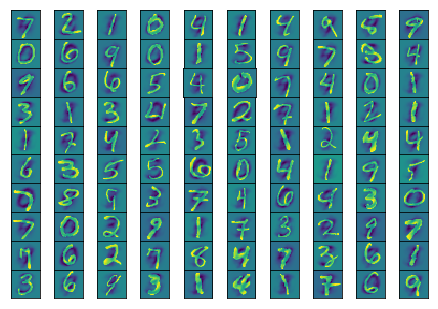

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
Preceision for 50 nearest neighbors:  
1.0
Recall for 50 nearest neighbors:  
0.26


In [9]:
mnist_width = 28
numVisible = mnist_width * mnist_width
numHidden = 5
corruption_level = 0.3

# create node for input data
X = tf.placeholder("float", [None, numVisible], name='X')

# create node for corruption mask
mask = tf.placeholder("float", [None, numVisible], name='mask')

# create nodes for hidden variables
maxInitW = 4 * np.sqrt(6. / (numVisible + numHidden))
initW = tf.random_uniform(shape=[numVisible, numHidden],
                           minval=-maxInitW,
                           maxval=maxInitW)

W = tf.Variable(initW, name='W')
b = tf.Variable(tf.zeros([numHidden]), name='b')

W_prime = tf.transpose(W)  # tied weights between encoder and decoder
b_prime = tf.Variable(tf.zeros([numVisible]), name='b_prime')


# build model graph
Z = model(X, mask, W, b, W_prime, b_prime)
Y = latent(X, mask, W, b, W_prime, b_prime)
# create cost function
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)  # construct an optimizer
predict_op = Z
latent_op = Y
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

trainX = trainX[:1000]
trainY = trainY[:1000]
testX = testX[:1000]
testY = testY[:1000]


# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(100):
        for start, end in zip(range(0, len(trainX), 128), range(128, len(trainX)+1, 128)):
            input_ = trainX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, testX.shape)
        if i%1000 ==0:
            print(i, sess.run(cost, feed_dict={X: testX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, testX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: testX[:100], mask: mask_np})
    latent_imgs = sess.run(latent_op, feed_dict={X: testX[:100], mask: mask_np})
    input_imgs = testX[:100]
    input_labs = testY[:100]


# Plot the reconstructed images
print()
print ('Predicted Images:')
plotImages(predicted_imgs,'pred')

print()
print("Printing reconstruction error: ")
loss = ((testX[:100] - predicted_imgs) ** 2).mean()
print(loss)

print()
print ('Input Images')
plotImages(input_imgs, 'input')


print ()
print ('plotting Loss')
plotImages(testX[:100] - predicted_imgs, 'loss')

#############################################
#Calculating latent space similarity

seed  = latent_imgs[0]
eudist = [0]

for i in range(len(latent_imgs)-1):
    eudist.append(np.linalg.norm(seed-latent_imgs[i+1]))

#print(eudist)
    
close = sorted(range(len(eudist)), key=lambda k: eudist[k])
close = close[:50]
#print(input_labs[close])
#vis(input_imgs[close], 'nearest')

tp =0
fn =0

neighbors = input_labs[close]
seed_lab = neighbors[0]
print(seed_lab)
for vec in range(len(neighbors)-1):
    if all(np.array(seed_lab) == np.array(neighbors[vec+1])):
        tp = tp+1
#print(tp)

fn = 50 - tp
fp = 0

print("Preceision for 50 nearest neighbors:  "),
print(float(tp)/float(tp+fp))
print("Recall for 50 nearest neighbors:  "),
print(float(tp)/float(tp+fn))

#################################################################

### N = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 54658.4
[  1.84267659e-08   1.00000000e+00   3.39450884e-10   1.00000000e+00
   8.21988380e-11   2.17329443e-07   7.10040750e-03   8.35329033e-08
   9.97072816e-01   2.93943732e-08]

Predicted Images:


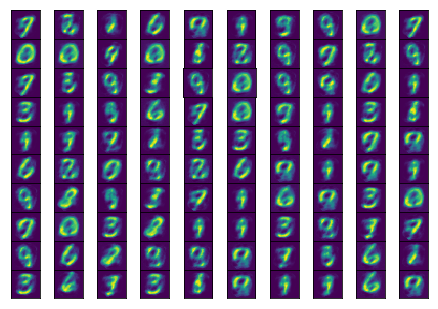


Printing reconstruction error: 
0.0515622

Input Images


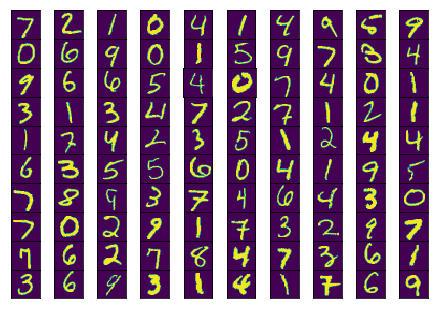


plotting Loss


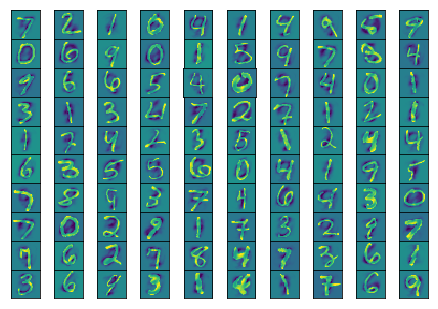

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
Preceision for 50 nearest neighbors:  
1.0
Recall for 50 nearest neighbors:  
0.2


In [7]:
mnist_width = 28
numVisible = mnist_width * mnist_width
numHidden = 10
corruption_level = 0.3

# create node for input data
X = tf.placeholder("float", [None, numVisible], name='X')

# create node for corruption mask
mask = tf.placeholder("float", [None, numVisible], name='mask')

# create nodes for hidden variables
maxInitW = 4 * np.sqrt(6. / (numVisible + numHidden))
initW = tf.random_uniform(shape=[numVisible, numHidden],
                           minval=-maxInitW,
                           maxval=maxInitW)

W = tf.Variable(initW, name='W')
b = tf.Variable(tf.zeros([numHidden]), name='b')

W_prime = tf.transpose(W)  # tied weights between encoder and decoder
b_prime = tf.Variable(tf.zeros([numVisible]), name='b_prime')


# build model graph
Z = model(X, mask, W, b, W_prime, b_prime)
Y = latent(X, mask, W, b, W_prime, b_prime)
# create cost function
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)  # construct an optimizer
predict_op = Z
latent_op = Y
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

trainX = trainX[:1000]
trainY = trainY[:1000]
testX = testX[:1000]
testY = testY[:1000]


# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(100):
        for start, end in zip(range(0, len(trainX), 128), range(128, len(trainX)+1, 128)):
            input_ = trainX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, testX.shape)
        if i%1000 ==0:
            print(i, sess.run(cost, feed_dict={X: testX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, testX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: testX[:100], mask: mask_np})
    latent_imgs = sess.run(latent_op, feed_dict={X: testX[:100], mask: mask_np})
    input_imgs = testX[:100]
    input_labs = testY[:100]


# Plot the reconstructed images
print()
print ('Predicted Images:')
plotImages(predicted_imgs,'pred')

print()
print("Printing reconstruction error: ")
loss = ((testX[:100] - predicted_imgs) ** 2).mean()
print(loss)

print()
print ('Input Images')
plotImages(input_imgs, 'input')


print ()
print ('plotting Loss')
plotImages(testX[:100] - predicted_imgs, 'loss')

#############################################
#Calculating latent space similarity

seed  = latent_imgs[0]
eudist = [0]

for i in range(len(latent_imgs)-1):
    eudist.append(np.linalg.norm(seed-latent_imgs[i+1]))

#print(eudist)
    
close = sorted(range(len(eudist)), key=lambda k: eudist[k])
close = close[:50]
#print(input_labs[close])
#vis(input_imgs[close], 'nearest')

tp =0
fn =0

neighbors = input_labs[close]
seed_lab = neighbors[0]
print(seed_lab)
for vec in range(len(neighbors)-1):
    if all(np.array(seed_lab) == np.array(neighbors[vec+1])):
        tp = tp+1
#print(tp)

fn = 50 - tp
fp = 0

print("Preceision for 50 nearest neighbors:  "),
print(float(tp)/float(tp+fp))
print("Recall for 50 nearest neighbors:  "),
print(float(tp)/float(tp+fn))

#################################################################

### MNIST with PCA

### N = 2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


C:\Users\Richa Sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


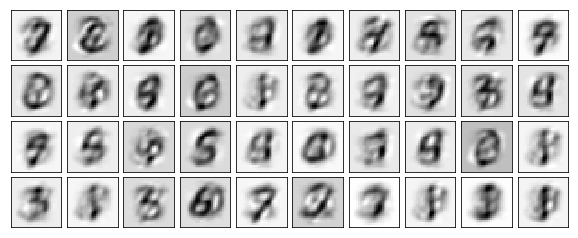

Printing reconstruction error: 
0.0438526


In [10]:
from sklearn import decomposition
from sklearn.decomposition import PCA
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt


def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='binary', interpolation='nearest')
    plt.show()


mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
numHidden = 2

trainX = trainX[:1000]
trainY = trainY[:1000]
testX = testX[:1000]
testY = testY[:1000]


pca = decomposition.RandomizedPCA(n_components=14, whiten=True)
pca.fit(trainX)
X_train_pca = pca.transform(trainX)
X_test_pca = pca.transform(testX)
filtered = pca.inverse_transform(X_test_pca)


plot_digits(filtered)
loss = ((testX - filtered) ** 2).mean()
print("Printing reconstruction error: ")
print(loss)

### N=5

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


C:\Users\Richa Sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


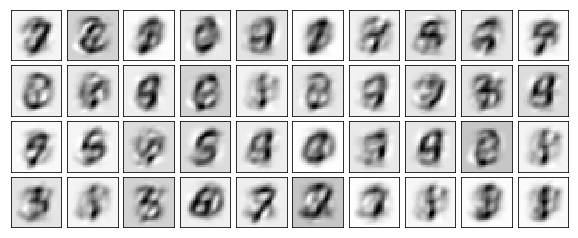

Printing reconstruction error: 
0.0439229


In [11]:
from sklearn import decomposition
from sklearn.decomposition import PCA
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt


def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='binary', interpolation='nearest')
    plt.show()


mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
numHidden = 5

trainX = trainX[:1000]
trainY = trainY[:1000]
testX = testX[:1000]
testY = testY[:1000]


pca = decomposition.RandomizedPCA(n_components=14, whiten=True)
pca.fit(trainX)
X_train_pca = pca.transform(trainX)
X_test_pca = pca.transform(testX)
filtered = pca.inverse_transform(X_test_pca)


plot_digits(filtered)
loss = ((testX - filtered) ** 2).mean()
print("Printing reconstruction error: ")
print(loss)

### N = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


C:\Users\Richa Sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


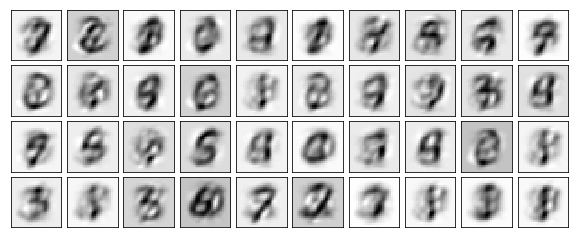

Printing reconstruction error: 
0.0439494


In [12]:
from sklearn import decomposition
from sklearn.decomposition import PCA
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt


def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='binary', interpolation='nearest')
    plt.show()


mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
numHidden = 10

trainX = trainX[:1000]
trainY = trainY[:1000]
testX = testX[:1000]
testY = testY[:1000]


pca = decomposition.RandomizedPCA(n_components=14, whiten=True)
pca.fit(trainX)
X_train_pca = pca.transform(trainX)
X_test_pca = pca.transform(testX)
filtered = pca.inverse_transform(X_test_pca)


plot_digits(filtered)
loss = ((testX - filtered) ** 2).mean()
print("Printing reconstruction error: ")
print(loss)

#### comparison of PCA and original method

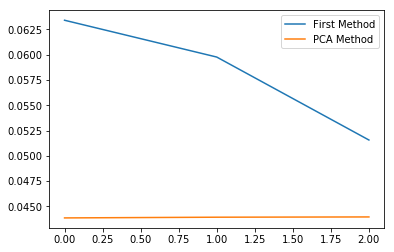

In [25]:
#reconstruction error in original method
from matplotlib import pyplot as plt

reconstOrig = [0.0634134, 0.0597712, 0.0515622]
reconstPCA = [0.0438526, 0.0439229, 0.0439494]
yLabel =  [0, 0.25, 0.5, 0.75, 1]

plt.plot( reconstOrig, label = 'First Method')
plt.plot( reconstPCA,label = 'PCA Method')

plt.legend()
plt.show()

#### As seen, the PCA method does better and does not change much with the variation of  hidden units. However the first method varies a lot with varying N.

### 3. Word2Vec

In [27]:
from gensim.models import KeyedVectors
import gensim
# Need the interactive Tools for Matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE


In [29]:
#Load the vectors
wordsList = []
wordVectors = np.zeros([20001,50], dtype=np.float32)
count = 0
vectorList = open('vectors_new.txt','r',encoding="utf8")

for line in vectorList:
    line = line.split(' ')
    dataVal = np.zeros(shape=(50,1))
    wordsList.append(line[0])
    for i in range(1,len(line)):
        dataVal[i-1] = float(line[i])
    dataVal = np.array(dataVal, dtype=np.float32).reshape(1,50)
    wordVectors[count] = dataVal
    count += 1
vectorList.close()

In [31]:
vecModel = KeyedVectors.load_word2vec_format('vectors_new.txt')

testWords = ['life','market','stanford','trump','public']

for w in testWords:
    print ('Twenty words similar to ' + str(w) + ' are below:')
    for similarWord in vecModel.similar_by_word(w, topn=20): #uses cosine similarity
        print (similarWord[0])
    
    print ()

Twenty words similar to life are below:
mind
love
lives
own
kind
experience
child
perhaps
she
whose
indeed
her
same
work
true
way
once
fact
this
much

Twenty words similar to market are below:
markets
prices
stock
buying
consumer
retail
stocks
price
sales
business
trend
rise
industry
sector
investors
trading
demand
economy
higher
analysts

Twenty words similar to stanford are below:
ucla
harvard
yale
princeton
rutgers
university
baylor
graduate
georgetown
cornell
usc
uc
hopkins
professor
berkeley
college
vanderbilt
ph.d.
purdue
penn

Twenty words similar to trump are below:
casino
casinos
hilton
mogul
vegas
murdoch
taj
mgm
gambling
hollywood
rockefeller
hotel
disney
luxury
condominium
owns
viacom
worldcom
carlton
tycoon

Twenty words similar to public are below:
private
office
attention
local
for
media
new
address
own
concerned
health
business
focused
services
administration
lack
critical
calls
giving
social



In [25]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsneModel = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    newVals = tsneModel.fit_transform(tokens)

    x = []
    y = []
    for value in newVals:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
    plt.savefig('wordVec.png')
    plt.show()

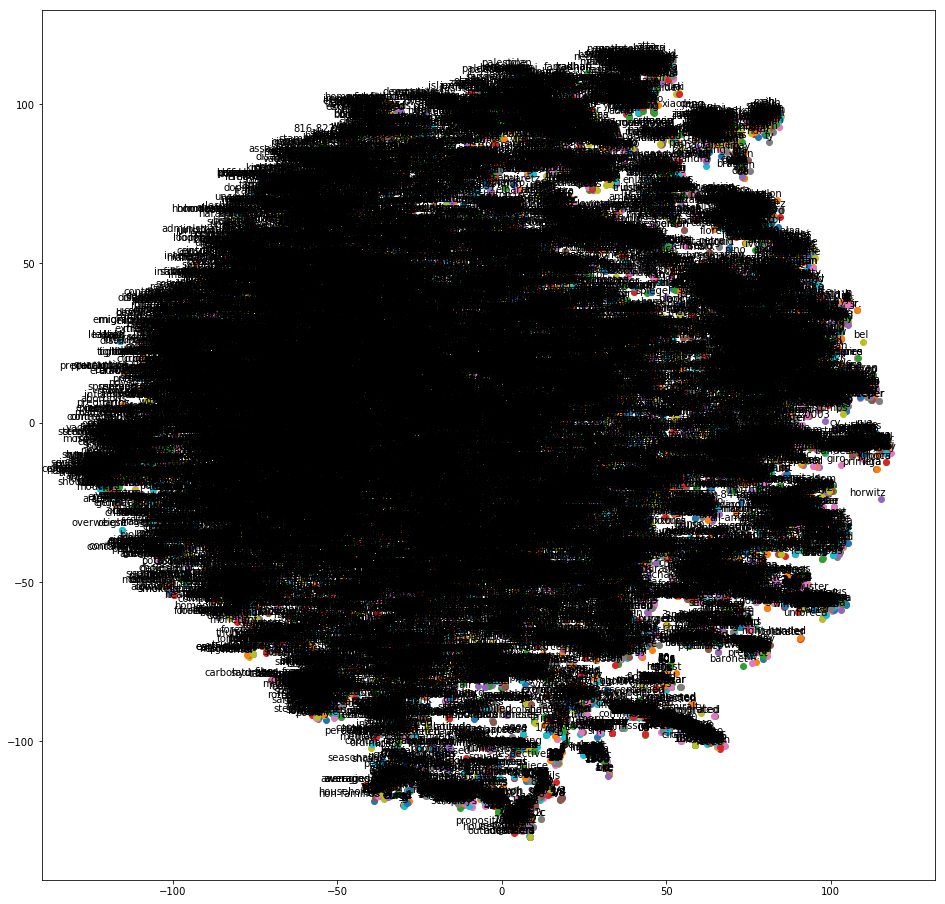

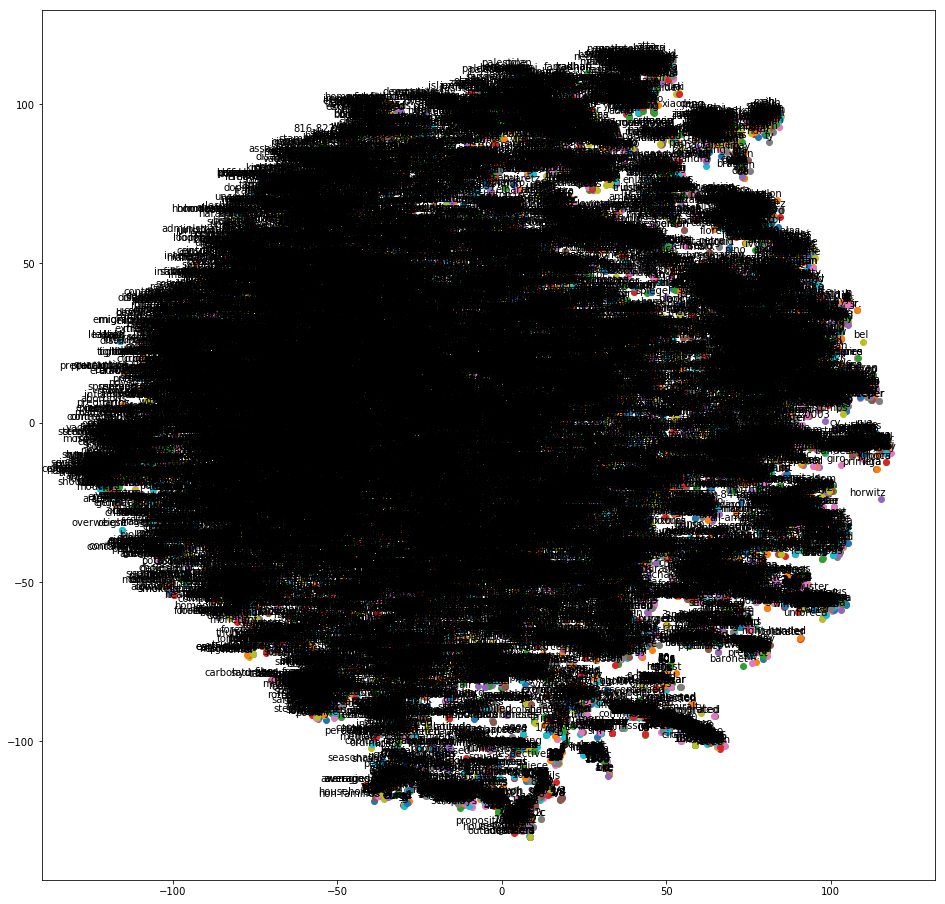

In [26]:
tsne_plot(vecModel)

In [32]:
#Inspired from a Medium Article by Aneesha Bakharia
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,50), dtype='f')
    word_labels = [word]

    # get close words
    similarWords = model.similar_by_word(word, 20)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in similarWords:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

<IPython.core.display.Javascript object>


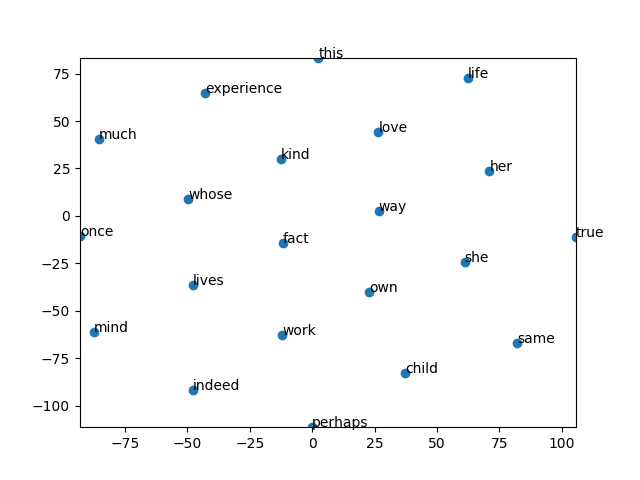

In [33]:
display_closestwords_tsnescatterplot(vecModel, 'life')

<IPython.core.display.Javascript object>


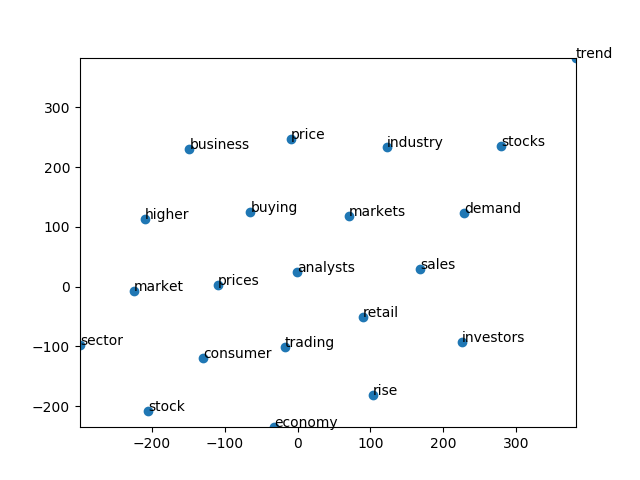

In [34]:
display_closestwords_tsnescatterplot(vecModel, 'market')

<IPython.core.display.Javascript object>


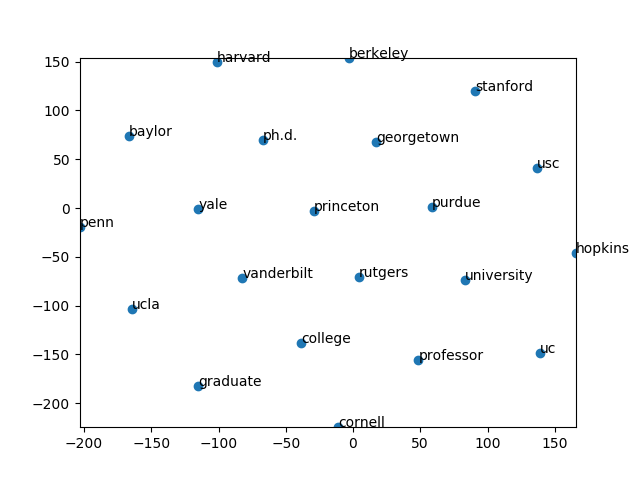

In [35]:
display_closestwords_tsnescatterplot(vecModel, 'stanford')

<IPython.core.display.Javascript object>


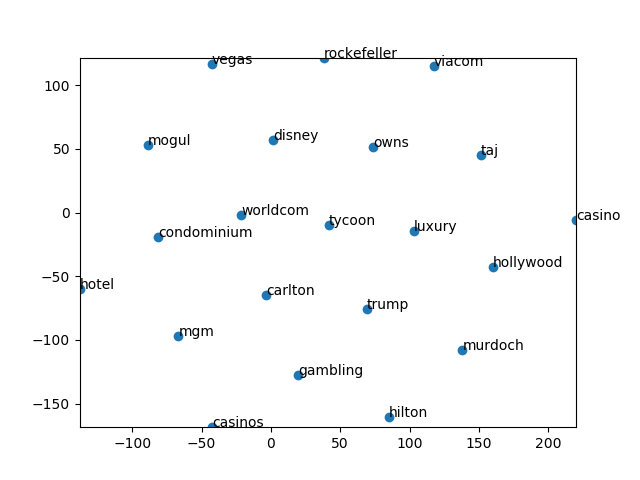

In [36]:
display_closestwords_tsnescatterplot(vecModel, 'trump')

<IPython.core.display.Javascript object>


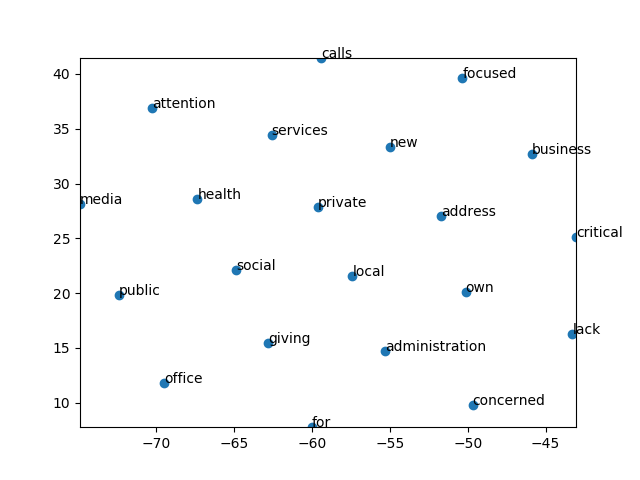

In [37]:
display_closestwords_tsnescatterplot(vecModel, 'public')